# Calculating laminar flame speeds and structure (In Progress)
*Daniel I Pineda, James L Urban, and Carlos Fernandez-Pello*, 2017

### Flame speed, structure
In this example, we go over the concept of an idealized flame---a one-dimensional flame. Different fuels display different flame behavior depending on the temperature, pressure, and equivalence ratio. Like the ignition delay calculations, chemical reactions and chemical reaction rates are relevant here; but additionally, we must also take into account the transport properties of our gas. This includes the diffusivities, thermal conductivities, and viscosities of each species. This code has been adapted from an [example flame code](http://www.cantera.org/docs/sphinx/html/cython/examples/onedim_adiabatic_flame.html), along with another [example code for sensitivity analysis](http://www.cantera.org/docs/sphinx/html/cython/examples/onedim_flamespeed_sensitivity.html) available at the Cantera website. 

### Import Packages
- [cantera](http://www.cantera.org/docs/sphinx/html/index.html): A Combustion Chemistry Python Module 
    - Chemical Equilibrium
    - 1-D Flame Speed
    - Surface Chemistry
- [numpy](http://www.numpy.org/): A Mathematical Function Libary (similiar functions to MATLAB) 
    - Linear Algegra
    - Root Finding
    - Simple Data Analysis
- [matplotlib](http://matplotlib.org/): A Python Figure making and Plotting Software 

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Intitialize Gas Object
For this example we will initialize a gas object ("`gas1`") using the [GRI-MECH 3.0 mechanism](http://combustion.berkeley.edu/gri-mech/version30/text30.html), which is a chemical kinetic mechanism optimized for natural gas combustion.

Here, the simulation will use all of the data that the mechanism has---thermodynamic data, chemical kinetic data, and transport data of the species in the mechanism. The simulation will be 0-D in time (steady state) and 1-D in space. The chemical kinetic and transport data will be used to calculate the steady-state species populations in space (or, for a steady-state inlet velocity, in time), and the thermodynamic data will be used to calculate the temperature changes in space depending on the mixture composition. 

In [2]:
gas1 = ct.Solution('gri30.xml')

### Set Initial Gas Mixture and Conditions
The gas mixture we will first examine will be a mixture with the following conditions:
- Composition: Stoichiometric methane ($CH_4$) and air
- $T = 300~K$
- $P = 101.325~kPa$

In [3]:
gas1.TP = 300, 101325   # [K], [Pa]
phi = 1
gas1.set_equivalence_ratio(phi,'CH4','O2:1,N2:3.76')

### Set up flame simulation parameters

Here, the simulation needs some parameters to establish the initial spatial domain and grid refine criteria. `width` defines the initial domain in meters. Flames at lower pressures tend to be thicker, while flames at high pressures tend to be thinner. The gas object `gas1` is used here as in input to `FreeFlame` to create a free flame object. 

In [4]:
width = 0.03  # domain size [m], need to increase for lower pressures and decrease for higher pressures
loglevel = 1  # amount of diagnostic output (0 to 8)

# Set up flame object
f = ct.FreeFlame(gas1, width=width)
f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
f.show_solution()



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> reactants <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:        1.123 kg/m^2/s 
    Temperature:        300 K 
    Mass Fractions: 
                      O2      0.2201 
                     CH4     0.05519 
                      N2      0.7247 



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> flame <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Pressure:   1.013e+05 Pa

-------------------------------------------------------------------------------
          z           u           V           T      lambda          H2 
-------------------------------------------------------------------------------
          0           1           0         300           0           0 
      0.006           1           0         300           0           0 
      0.009           1           0         300           0           0 
     0.0105       2.618           0       781.4           0   6.623e-05 
      0.012       4.237           0        1263           0   0.0001325 
      0.0

The initial solution guess is shown, where at `z = 0`, the temperature is the initial temperature of `gas1`, 300 K. Over a small distance, a linear interopolation is made to the adiabatic flame temperature of `gas1` at equilibrium, which is 2226 K here. The mole fractions of different species have also been similarly interpolated from reactants to products over this small domain. Next, we define the `transport_model` for the flame, and perform a solution. The flame object `f` contains all of the solution information. `f.u` contains the array of velocity values, and `f.u[0]` is the first element at `z=0`, i.e., the unburned laminar flame speed. This object will evolve as the solver refines the grid, adds more grid points, and builds species and temperature profiles. 

In [5]:
# Solve with mixture-averaged transport model
f.transport_model = 'Mix'
f.solve(loglevel=loglevel, auto=True)
f.show_solution()
print('Initial baseline mixture-averaged flamespeed = {0:7f} m/s'.format(f.u[0]))


************ Solving on 9 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      4.919
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005474      3.936
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002192      5.536
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     6.502e-06      6.502
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001666      4.794
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.004271      3.656
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement d

We see that there were a few iterations during the solution of the flame when using mixture-averaged transport properties. After each iteration, the number of grid points increased, and---although not obvious without plotting---the species and temperature profiles transformed from their initial linearly-interpolated guesses into finer curves. Eventually, we converged on a solution in which the unburned gas velocity was around 38 cm/s. 

We can examine the species and temperature profiles using `matplotlib` below. 

<IPython.core.display.Javascript object>


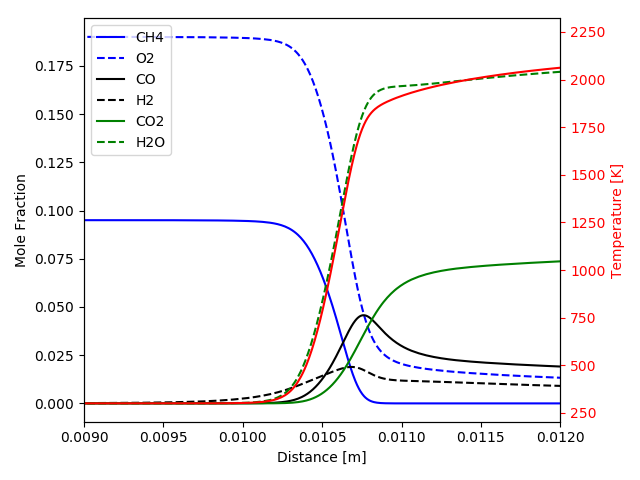

In [6]:
fig, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig'

# now, plot the species mole fractions as a function of space:
ax1.plot(f.grid, f.X[gas1.species_index('CH4')], 'b-', label='CH4')
ax1.plot(f.grid, f.X[gas1.species_index('O2')], 'b--', label='O2')
ax1.plot(f.grid, f.X[gas1.species_index('CO')], 'k-', label='CO')
ax1.plot(f.grid, f.X[gas1.species_index('H2')], 'k--', label='H2')
ax1.plot(f.grid, f.X[gas1.species_index('CO2')], 'g-', label='CO2')
ax1.plot(f.grid, f.X[gas1.species_index('H2O')], 'g--', label='H2O')

ax1.set_ylabel('Mole Fraction', color='k')
ax1.set_xlabel('Distance [m]')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(f.grid, f.T, 'r-')
ax2.set_ylabel('Temperature [K]', color='r')
ax2.tick_params('y', colors='r')

plt.xlim((0.009,0.012))
fig.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot


Although the mixture-averaged transport properties assumption is good for many flame conditions, there are many cases in which we may want to account for the fact that each of the species has a different set of properties---for example, both molecular and atomic hydrogen are very light species, and as such their diffusivities are orders of magnitude higher than the other species in the gas. For hydrogen-rich flames, we may want to invoke a multicomponent transport model by setting the transport model to `Multi`, as shown next.

In [7]:
# Solve with multi-component transport properties
f.transport_model = 'Multi'
f.solve(loglevel) # don't use 'auto' on subsequent solves
f.show_solution()
print('Initial baseline multicomponent flamespeed = {0:7f} m/s'.format(f.u[0]))


..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [184] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 107 123 
    to resolve CH CH2 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [186] point grid(s).

..............................................................................
no new points needed in flame


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> reactants <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:       0.4298 kg/m^2/s 
    Temperature:        300 K 
    Mass Fractions: 
                 

One thing to notice immediately is that each iteration of this simulation took a much longer time to run, even though the calculation started with the falem object `f` that had already been calculated, so we simply refined the solution we had before. Additionally, the resulting laminar unburned flame speed increased by a small amount. Methane-air flames (and fuels with high H-to-C ratios) tend to produce more hydrogen as an intermediate species, and these hydrogen species diffuse further into the unburned gas, reacting "earlier" in the flame. 

We can extend this line of thinking to analyze what species and reactions are most influential in this particular flame speed calculation. Typically, the most important reactions are those that are either chain-branching reactions (producing many radical species), reactions that release a lot of heat, or a combination of both. To get an idea of the influence of specific reactions on the flame speed, we can conduct a sensitivity analysis:

Sensitivity = $\frac{k}{S}\cdot \frac{dS}{dk}$

where $k$ is the reaction rate of a particular reaction, $S$ is the unburned flame speed, and $dS$ is the change in $S$ that results from a corresponding change in $k$, $dk$. 

In [8]:
# calculate sensitivities
sens1 = f.get_flame_speed_reaction_sensitivities()

# print the reaction number followed by the associated sensitivity 
print()
print('Rxn #   k/S*dS/dk    Reaction Equation')
print('-----   ----------   ----------------------------------')
for m in range(gas1.n_reactions):
    print('{: 5d}   {: 10.3e}   {}'.format(
          m, sens1[m], gas1.reaction_equation(m)))
    

()
Rxn #   k/S*dS/dk    Reaction Equation
-----   ----------   ----------------------------------
    0   -1.561e-04   2 O + M <=> O2 + M
    1   -7.044e-04   H + O + M <=> OH + M
    2    2.734e-02   H2 + O <=> H + OH
    3   -4.524e-03   HO2 + O <=> O2 + OH
    4   -1.752e-05   H2O2 + O <=> HO2 + OH
    5   -1.052e-03   CH + O <=> CO + H
    6   -3.757e-03   CH2 + O <=> H + HCO
    7   -2.987e-04   CH2(S) + O <=> CO + H2
    8   -5.530e-05   CH2(S) + O <=> H + HCO
    9   -1.235e-02   CH3 + O <=> CH2O + H
   10    4.643e-03   CH4 + O <=> CH3 + OH
   11   -2.977e-03   CO + O (+M) <=> CO2 (+M)
   12   -4.247e-03   HCO + O <=> CO + OH
   13   -2.935e-03   HCO + O <=> CO2 + H
   14    3.494e-03   CH2O + O <=> HCO + OH
   15   -1.467e-04   CH2OH + O <=> CH2O + OH
   16   -1.388e-04   CH3O + O <=> CH2O + OH
   17    2.013e-04   CH3OH + O <=> CH2OH + OH
   18    8.628e-05   CH3OH + O <=> CH3O + OH
   19   -6.623e-06   C2H + O <=> CH + CO
   20    1.010e-03   C2H2 + O <=> H + HCCO
   21    5

You'll notice that that took a while, and in general, sensitivity analyses do, because they typically perturb the solution one reaction at a time---the larger the reaction mechanism, the longer this takes. We now have a list of reactions and associated sensitivites, ordered by the reaction number, which is just in the same order as the reactions were listed in the original mechanism file. This is not necessarily the most convenient way to look at the most influential reactions, and so we can re-order the sensitivity output to correspond to the most influential reactions using some functions of the `numpy` Python package

()
Rxn #   k/S*dS/dk    Reaction Equation
-----   ----------   ----------------------------------
   37    5.228e-01   H + O2 <=> O + OH
   51   -1.580e-01   CH3 + H (+M) <=> CH4 (+M)
   98    1.092e-01   CO + OH <=> CO2 + H
   96    7.251e-02   CH3 + OH <=> CH2(S) + H2O
  118    7.180e-02   CH3 + HO2 <=> CH3O + OH
   34   -6.695e-02   H + H2O + O2 <=> H2O + HO2
  165    5.631e-02   H2O + HCO <=> CO + H + H2O
  283    5.111e-02   CH3 + O => CO + H + H2
  166    4.392e-02   HCO + M <=> CO + H + M
   97   -3.998e-02   CH4 + OH <=> CH3 + H2O
   52   -3.953e-02   CH4 + H <=> CH3 + H2
   44   -3.890e-02   H + HO2 <=> H2 + O2
   54   -3.797e-02   H + HCO <=> CO + H2
  157   -3.700e-02   2 CH3 (+M) <=> C2H6 (+M)
   42   -3.278e-02   H + OH + M <=> H2O + M
  167   -2.883e-02   HCO + O2 <=> CO + HO2
    2    2.734e-02   H2 + O <=> H + OH
  289    2.598e-02   CH2 + O2 => CO2 + 2 H
   99   -1.998e-02   HCO + OH <=> CO + H2O
   73    1.876e-02   C2H4 + H (+M) <=> C2H5 (+M)
  143    1.857e-02   CH2

<IPython.core.display.Javascript object>


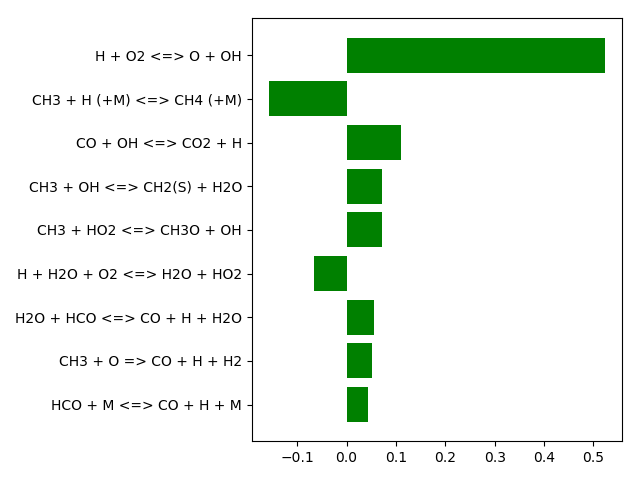

In [9]:
# use argsort to obtain an array of the *indicies* of the values of the sens1 array sorted by absolute value 
newOrder = np.argsort(np.abs(sens1))
# argsort ranks from small to large, but we want large to small, so we flip this around 
newOrder = newOrder[::-1] 

# make some storage variables so that we can plot the results later in a bar graph
newOrder2 = np.zeros(len(newOrder))
sens2 = np.zeros(len(newOrder))
reactionList = []

# using the same method above, print the sensitivties but call the new indicies that we defined 
print()
print('Rxn #   k/S*dS/dk    Reaction Equation')
print('-----   ----------   ----------------------------------')
for ii in range(gas1.n_reactions):
    print('{: 5d}   {: 10.3e}   {}'.format(
          newOrder[ii], sens1[newOrder[ii]], gas1.reaction_equation(newOrder[ii])))
    # assign new variables values for plot use
    newOrder2[ii] = ii
    sens2[ii] = sens1[newOrder[ii]]
    reactionList.append(gas1.reaction_equation(newOrder[ii]))

# generate horizontal bar graph 
numTopReactions = 10; # how many of the top reactions do we want to look at?

plt.rcdefaults()
fig, ax = plt.subplots()
# plot results
ax.barh(newOrder2[0:numTopReactions-1], sens2[0:numTopReactions-1], align='center',
        color='green', ecolor='black')
# make sure that every single tick on the y-axis is marked
ax.set_yticks(np.arange(len(reactionList[0:numTopReactions-1])))
# label these y-ticks with the reaction in question
ax.set_yticklabels(reactionList[0:numTopReactions-1])
# invert the y-axis so that the most sensitive reaction is at the top instead of the bottom
ax.invert_yaxis()
fig.tight_layout()
plt.show()

We now see that the most significant reaction is that of reaction 37, H + O2 <=> O + OH, a chain branching reaction often considered the most important reaction in combustion. The value of this sensitivity is positive---if the reaction rate of reaction 37 is increased, the flame speed increases. 

The next most influential reaction is a third-body collision reaction, CH3 + H (+M) <=> CH4 (+M). We see that the value of this sesnitivity is negative---if the reaction rate is increased, the flame speed decreases. This makes sense, since the forward direction of this reaction is converting two radicals back into a methane molecule, which is generally the reverse of what normally happens in combustion. 